# Gap Filling

## Steps
1. Linearly interpolate gaps in $\mathbf{y}$ less than $tol$ timesteps
2. For each data gap:
  - find $k$ most similar days
  - calculate average daily cycle $\overline{\mathbf{y}} = (\overline{y_1}, \overline{y_2}, ..., \overline{y_t})$
  - rescale $\overline{\mathbf{y}}$ to match bounding observations ($d\mathbf{y} = \mathbf{y} - \overline{\mathbf{y}}$, linearly interpolate $d\mathbf{y}$ where $\mathbf{y} \notin \mathbb{R}$)
  - calculate gap filled observations ($\hat{\mathbf{y}} = \overline{\mathbf{y}} + d\mathbf{y}$)
  - replace missing values ($\mathbf{y} = \hat{\mathbf{y}}$ where $\mathbf{y} \notin \mathbb{R}$)

### Good for
* variables with diurnal cycles
* gaps that you're not comfortable filling linearly or with the mean
* data with only a few missing variables (doesn't fill fully-missing days)

In [1]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# Functions

In [2]:
# vectorized linear interpolation
def linear_fill(df, tol):
    # so awesome!
    dfc = df.copy().as_matrix().T
    df = df.interpolate()
    inan = np.isnan(dfc)
    csum = np.cumsum(np.invert(inan),axis=1)
    mask = np.array([np.in1d(csum[c],np.where(np.bincount(csum[c])>tol)[0])*inan[c] for c in xrange(len(dfc))])
    mask = pd.DataFrame(mask.T, columns=df.columns, index=df.index)
    df[mask] = np.nan
    return df

In [3]:
# find similar k days
def topk(df, k, minobs=3):
    D = [[] for _ in xrange(len(df))] # initialize empty list
    # rows with missing data, exclude first and last
    narows = np.sort(list(set(np.where(np.isnan(df))[0])))[1:-1]
    # for each row with missing data, find similar rows without missing data
    for i in narows:
        # skip days with less than n observations... hard to say anything about similarity
        if len(df[i][~np.isnan(df[i])]) < minobs:# alternatively, skip if all(np.isnan(df[i])):
            continue
        xdelt = df[i] - df
        delt = np.zeros(len(df))*np.nan # initiate row indexes with nan
        # candidate rows = only rows without nan
        jj = np.arange(len(df))[np.invert(np.in1d(np.arange(len(df)), narows))]
        for j in jj:
            tt = xdelt[j]
            wn = np.isnan(tt)
            # skip comparisons with all nan rows (or self) or limited comparison data
            if j==i or all(wn):
                continue
            # Euclidean distance, not normalized by the length of vectors (don't care about absolute distance)
            delt[j] = np.dot(tt[~wn],tt[~wn])
        # get top k matches
        D[i] = np.array(delt).argsort()[:k].tolist()
    return D

In [4]:
# data prep function for fill_gaps
# adds snap points, gets average data
def prep_missing(dfc, xd, mm):
    # dfc is the data frame
    # xd is the data frame of days
    # mm is the list of missing days
    #
    ### MISSING DATA
    missing = dfc[np.in1d(dfc.index.date, xd.index[mm].date)]
    # If missing full day, extend timeseries to include neighbor days (as long as not first or last day)
    if any(np.isnan(missing.iloc[[0,-1]].as_matrix().max(axis=0))):
        if mm[0] is not 1:
            mm = [mm[0]-1] + mm
        if mm[-1] is not len(mm)-1:
            mm = mm + [mm[-1]+1]
        missing = dfc[np.in1d(dfc.index.date, xd.index[mm].date)].interpolate(limit=1,limit_direction='both')
        # If data missing still (i.e., first/last day), add average of first and last rows at start and end
        if any(np.isnan(missing.iloc[[0,-1]].as_matrix().max(axis=0))):
            missing.iloc[[0,-1],:] = np.nanmean(missing.iloc[[0,-1]].as_matrix(), axis=0)
    #
    ndays = len(set(missing.index.date))
    ### SIMILAR DATA
    # grab similar days - tuples of missing day and similar day - this is really messy, sorry!
    list_similar = [[(mis, sim) for sim in ns[mis]] if len(ns[mis])>0 else [(mis, mis)] for mis in mm]
    unravel_similar = [item for sublist in list_similar for item in sublist]
    ss = pd.DataFrame(unravel_similar, columns=['group','match']) # make it a data frame
    # Get similar data, by merging the data with the groups
    similar = pd.merge(ss, dfc, left_on=xd.index[ss.match].date, right_on=dfc.index.date, \
        left_index=True).drop(['key_0','match'],1)
    # Group by group index to get similar days
    similar = similar.groupby([similar.index.time,xd.index[similar.group].date]).mean().reset_index()
    similar['DateTime_UTC'] = pd.to_datetime(similar.level_1.astype(str)+" "+similar.level_0.astype(str))
    # Get the matching data frame for filling
    similar = similar.drop(['level_0','level_1','group'],1).set_index('DateTime_UTC').sort_index()
    ### DAILY SNAP POINTS
    # if span mulitple days, add snap points at each new day to rescale
    #     and make sure that values 'touch' at each new day
    newdaypoints = np.in1d(missing.index.time, similar.index[[0,-1]].time)
    daypoints = missing.iloc[newdaypoints,:]
    if any(np.isnan(daypoints)):
        dayfill = daypoints.interpolate()
        missing.update(dayfill)
    #
    assert all(similar.index==missing.index) # need to match dimensions and align
    return missing, similar


In [5]:
def fill_gaps(df, ns, xd, lim=0):
    # df is the data frame
    # ns are the similar days for each day
    # xd is the daily data
    # lim is the minimum number of days to fill
    #     will not fill gaps that are less than this
    #     used for testing (b/c the test data have pre-existing gaps)
    dfc = df.copy()
    # the days that need filling
    filld = np.where([len(a)>0 for a in ns])[0]
    # groups for each missing block
    group = np.append(np.array([0]),np.cumsum(np.diff(filld)>1))
    for g in set(group):
        # grab missing days
        mm = filld[group==g].tolist()
        if len(mm)>=lim:
            missing, similar = prep_missing(dfc, xd, mm)
            # calculate predictions
            dy = (missing-similar)*missing.notnull() # notnull might not be necessary?
            dyhat = dy.interpolate()
            filled = similar + dyhat
            dfc.loc[filled.index,:] = filled
    return dfc

# Bring in data

In [8]:
x = pd.read_csv("CT_Farmington.csv")
x0 = x.copy()[[c for c in x.columns if c not in ['region','site','Discharge_m3s']]] \
    .set_index(pd.to_datetime(x['DateTime_UTC'])).resample("15Min").mean()
# delete some bad data values -- these are clearly skewed
x0.loc[(x0.index>"2016-04-10")&(x0.index<"2016-04-17"),x0.columns=='DO_mgL'] = np.nan
x0.loc[(x0['CDOM_mV']<55)|(x0['CDOM_mV']>160),x0.columns=="CDOM_mV"] = np.nan
# offset time to local
lng = -72.7594
mean_sol = timedelta(minutes=3.989*lng)
x0.index = x0.index+mean_sol
x0.columns

Index([u'AirPres_kPa', u'CDOM_mV', u'DO_mgL', u'SpecCond_uScm',
       u'Turbidity_NTU', u'USGSDepth_m', u'USGSDischarge_m3s', u'WaterTemp_C',
       u'pH'],
      dtype='object')

In [9]:
x0.DO_mgL.mean(), x0.CDOM_mV.mean()

(9.182572906662045, 82.94079690902352)

# Loop over k-folds

In [10]:
kneighbor = 3 # number of similar days to consider
# for each gap length:
gaps = [1,3,7,14,21]
# do DO_mgL and CDOM_mV -- different dynamics
maskvars = ["DO_mgL","CDOM_mV"]
maskvar = maskvars[0]

In [11]:
output = pd.DataFrame()
for gapwindow in gaps:
    # set up k-folds
    alldays = np.sort(list(set(x0.index.date)))
    breaks = np.array_split(alldays,int(len(alldays)/gapwindow))

    preds = pd.DataFrame()
    print str(gapwindow)+" day gaps / "+str(len(breaks))+" folds"
    for k in xrange(len(breaks)):
        if round(100*k/len(breaks),2) % 50 == 0:
            print str(round(100*k/len(breaks))) + "%"
        xx = x0.copy()
        xx = linear_fill(xx, tol=8) # 2 hour limit
        mask = np.in1d(xx.index.date, breaks[k])
        #maskcols = xx.columns==maskvar
        maskcols = np.in1d(xx.columns, maskvars)
        xx.iloc[mask, maskcols] = np.nan
        # resample to daily interval
        xsu = xx.resample('D').sum()
        xsz = xx.resample('D').count()
        # xsd = xx.resample('D').max() - xx.resample('D').min()
        xsz[xsz<96] = np.nan # missing obs
        xd = xsu/xsz # daily average
        # find top k similar days for each day
        ns = topk(xd.as_matrix(), k=kneighbor)
        # fill the gaps...
        x2 = fill_gaps(xx, ns, xd, lim=gapwindow)
        # save modeled data
        wn = np.isnan(xx[maskvar])
        out = pd.concat([x0[maskvar][wn], x2[maskvar][wn]], axis=1).dropna()
        preds = pd.concat([preds,out])

    preds.columns = ['Observed','Predicted']
    print "100% Complete"
    correlation = preds.corr().iloc[0,1]
    rmspe = np.sqrt(np.mean((preds.iloc[:,0]-preds.iloc[:,1])**2))
    output = pd.concat([output,pd.DataFrame([[gapwindow, correlation, rmspe]],columns=["gap","corr","rmspe"])])
output['var'] = maskvar


1 day gaps / 542 folds
0.0%


/home/aaron/anaconda2/lib/python2.7/site-packages/pandas/core/frame.py:3863: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  raise_on_error=True)
/home/aaron/anaconda2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


0.0%
0.0%
0.0%
0.0%
0.0%
50.0%
50.0%
50.0%
50.0%
50.0%
50.0%
100% Complete
3 day gaps / 180 folds
0.0%
0.0%
50.0%
50.0%
100% Complete
7 day gaps / 77 folds
0.0%
50.0%
100% Complete
14 day gaps / 38 folds
0.0%
50.0%
100% Complete
21 day gaps / 25 folds
0.0%
100% Complete


In [13]:
output

,gap,corr,rmspe,var
0,1,0.985376,0.342904,DO_mgL
0,3,0.979581,0.401627,DO_mgL
0,7,0.963863,0.508625,DO_mgL
0,14,0.929451,0.666656,DO_mgL
0,21,0.919777,0.734017,DO_mgL


In [35]:
#out1 = output
out2 = output
out1, out2

(   gap      corr     rmspe     var
 0    1  0.987529  0.323376  DO_mgL
 0    3  0.979940  0.405019  DO_mgL
 0    7  0.965130  0.511932  DO_mgL
 0   14  0.928440  0.754727  DO_mgL
 0   21  0.920185  0.740518  DO_mgL,    gap      corr      rmspe      var
 0    1  0.950181   4.745878  CDOM_mV
 0    3  0.919580   5.938238  CDOM_mV
 0    7  0.861732   7.686637  CDOM_mV
 0   14  0.587357  13.667666  CDOM_mV
 0   21  0.645174  11.830810  CDOM_mV)

In [38]:
output = pd.concat([out1,out2])
#output.to_csv("gap_filling_output.csv",index=False)

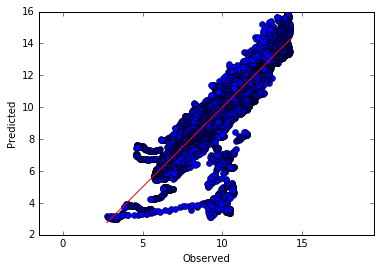

Correlation: 0.933
RMSPE (mg/L): 0.73


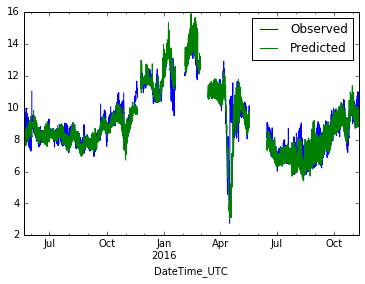

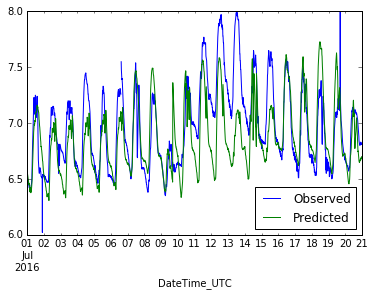

In [92]:
# plt.plot(preds.iloc[:,0],preds.iloc[:,1],"bo")
# ll = np.nanpercentile(preds.iloc[:,0].tolist(),[0,100])
# plt.plot(ll,ll,"r-")
# plt.ylabel('Predicted')
# plt.xlabel('Observed')
# plt.axis("equal")
# plt.show()

# print "Correlation: "+str(round(preds.corr().iloc[0,1],3))

# #sqrt mean of diff **2
# print "RMSPE (mg/L): "+str(round(np.sqrt(np.mean((preds.iloc[:,0]-preds.iloc[:,1])**2)),3))

# ppp = preds.resample("15min").mean() # need to 'resample' to get rid of lines over missing timespans
# ppp.plot()
# ppp.plot(xlim=(datetime(2016,7,1),datetime(2016,7,21)),ylim=(6,8))

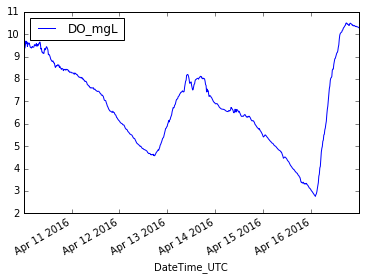

# Benchmarks - pretty fast...

In [39]:
# fill gaps that can be done linearly (here, less than 2 hours)
%time xx = linear_fill(xx, tol=8)

CPU times: user 20 ms, sys: 4 ms, total: 24 ms
Wall time: 23.6 ms


In [40]:
# find top k similar days for each day
# only matches the missing days
%time ns = topk(xd.as_matrix(), k=kneighbor)

CPU times: user 160 ms, sys: 4 ms, total: 164 ms
Wall time: 164 ms


In [41]:
# fill the gaps...
%time x2 = fill_gaps(xx, ns, xd)

CPU times: user 4.84 s, sys: 16 ms, total: 4.85 s
Wall time: 4.83 s
